Plot the distribution of GMM

In [2]:
%matplotlib inline
import sys
import os
import numpy as np
import torch
import dill
import json
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe

PYTHONAPI_EGG_PATH = f"{ os.environ['HOME'] }/src/carla/PythonAPI/carla/dist/carla-0.9.11-py3.7-linux-x86_64.egg"
CARLA_COLLECT_PATH = f"{ os.environ['HOME'] }/code/robotics/carla-collect"
sys.path.append('../../trajectron')
sys.path.append(PYTHONAPI_EGG_PATH)
sys.path.append(CARLA_COLLECT_PATH)

import utility as util
from helper import load_model, prediction_output_to_trajectories
import visualization
from model.dataset import *
from model.components import *
from model.model_utils import *

from model.components.discrete_latent import DiscreteLatent

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'olive', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 3) % len(AGENT_COLORS) for i in range(17)], 0)

NCOLORS = len(AGENT_COLORS)

Search for CARLA datasets

In [5]:
search_datasets = False
dataset_dir = f"{ os.environ['HOME'] }/code/robotics/carla-collect"
glob(f"{ dataset_dir }/**/*.pkl") if search_datasets else []

[]

In [6]:
dataset_0 = util.AttrDict(
    test_set_path='../processed/nuScenes_test_full.pkl',
    desc="NuScenes test set")

dataset_1 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_dataset/carla_test_v2_full.pkl',
    desc="CARLA synthesized dataset with bitmap mis-matched from NuScenes",
    v2_bitmap=True)

dataset_2 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_test_v2_1_full.pkl',
    desc="CARLA synthesized dataset")

dataset_3 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/carla_test_v2_1_1_full.pkl',
    desc="CARLA synthesized dataset smaller sized")

dataset = dataset_0
with open(dataset.test_set_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
print(dataset.desc)

NuScenes test set


Load NuScenes dataset

Search models

In [8]:
search_models = False
[x[0] for x in os.walk('models')] if search_models else None

Load model

In [9]:
model_1 = util.AttrDict(
        path='models/20210622/models_20_Jun_2021_23_53_04_carla_v2_1_dynmap',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on carla v2_1 dataset)")

model_2 = util.AttrDict(
        path='models/20210603/models_06_Jun_2021_17_02_01_carla_v2_K12',
        desc="Base model +Dynamics Integration, Maps with K=12 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_3 = util.AttrDict(
        path='models/20210622/models_19_Mar_2021_22_14_19_int_ee_me_ph8',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on NuScenes dataset)")

model_4 = util.AttrDict(
        path='models/20210713/models_03_Jul_2021_23_44_36_carla_v2_1_dynmap_K6',
        desc="Base model +Dynamics Integration, Maps with K=6 latent values "
             "(on carla v2_1 dataset)")

model_5 = util.AttrDict(
        path='models/20210610/models_16_Jun_2021_20_33_57_carla_v2_base_ph6',
        desc="Base model with K=25 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_6 = util.AttrDict(
        path='models/models_14_Jul_2021_17_55_12_carla_v2_1_1_base_ph6',
        desc="Base model with K=25 latent values "
             "(trained on small carla v2_1_1 dataset)")

model = model_3
eval_stg, hyp = load_model(model.path, eval_env, ts=20)#, device='cuda')
print(model.desc)


Loading from models/20210622/models_19_Mar_2021_22_14_19_int_ee_me_ph8/model_registrar-20.pt
Loaded!

Base model +Dynamics Integration, Maps with K=25 latent values (on NuScenes dataset)


In [30]:
hyp['MLP_dropout_keep_prob']
c = DiscreteLatent.all_one_hot_combinations(2,3)
c.shape
# hyperparams['dynamic'][self.node_type]['name']
hyp['dynamic']

{'PEDESTRIAN': {'name': 'SingleIntegrator',
  'distribution': True,
  'limits': {}},
 'VEHICLE': {'name': 'Unicycle',
  'distribution': True,
  'limits': {'max_a': 4,
   'min_a': -5,
   'max_heading_change': 0.7,
   'min_heading_change': -0.7}}}

### Combining forecast and map

In [10]:
scene = eval_scenes[25]
ph = 8
num_samples = 200
t = 15
timesteps = np.array([t])

In [11]:
def render_roads(ax, scene, is_white=False):
    road_color = 'white' if is_white else 'grey'
    map_mask = scene.map['VEHICLE'].as_image()
    # map_mask has shape (y, x, c)
    road_bitmap = np.max(map_mask, axis=2)
    road_div_bitmap = map_mask[..., 1]
    lane_div_bitmap = map_mask[..., 0]

    # extent = (scene.x_min, scene.x_max, scene.y_min, scene.y_max)
    extent = (0, scene.x_size, 0, scene.y_size)

    if 'v2_bitmap' in model:
        if 'v2_bitmap' not in dataset:
            print('WARNING: dataset not v2')
        # map_mask has shape (y, x, c)
        road_bitmap = np.max(map_mask, axis=2)
        road_div_bitmap = map_mask[..., 1]
        lane_div_bitmap = map_mask[..., 0]

        # Axes.imshow() expects (y, x, c)
        ax.imshow(road_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
        ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
        ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))
    else:
        if 'v2_bitmap' in dataset:
            print('WARNING: dataset is v2')
        """
        NuScenes bitmap format
        scene.map[...].as_image() has shape (y, x, c)
        Channel 1: lane, road_segment, drivable_area
        Channel 2: road_divider
        Channel 3: lane_divider
        """
        # NuScenes
        road_bitmap = np.max(map_mask, axis=2)
        road_bitmap = map_mask[..., 0]
        road_div_bitmap = map_mask[..., 1]
        lane_div_bitmap = map_mask[..., 2]
        ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
        ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
        ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))

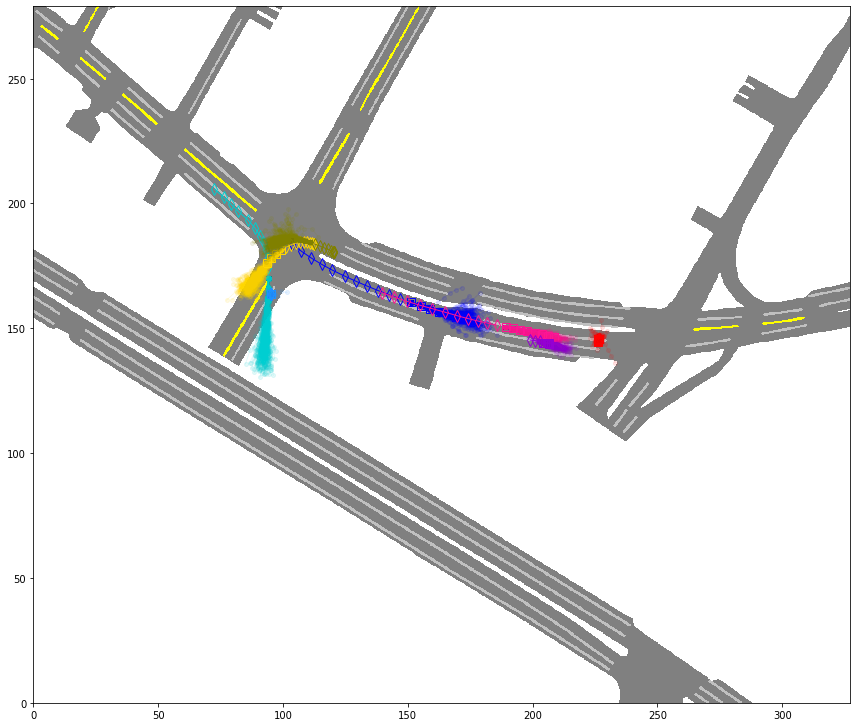

In [12]:
with torch.no_grad():
    # eval_stg the model interface
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=False,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
node = v_nodes[0]

fig, ax = plt.subplots(figsize=(12,15))
render_roads(ax, scene)

for idx, node in enumerate(v_nodes):
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]

    ax.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    ax.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        ax.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, alpha=0.1, markersize=4)

ax.set_xlim([0, scene.x_size])
ax.set_ylim([0, scene.y_size])
fig.tight_layout()
None

### Obtain the analytical PMF of p(z|x)

Obtain the PMF of p(z|x) via tf.distribution.OneHotCategorical.probs

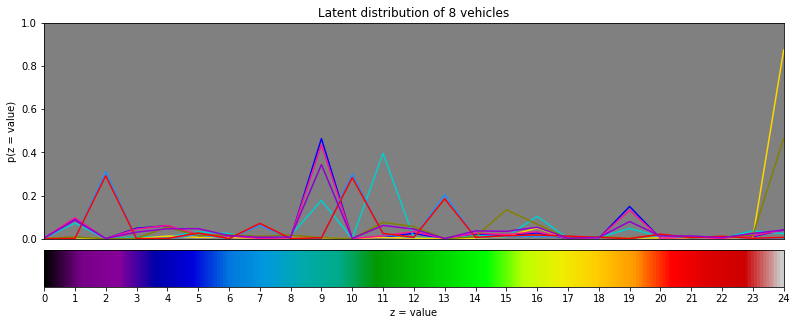

In [13]:
def generate_vehicle_latent_probs(
            z_mode=False, gmm_mode = False, full_dist = False, all_z_sep = False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)
    
    # model.latent is a DiscreteLatent
    # model.latent.p_dist is a tf.distribution.OneHotCategorical
    model.latent.p_dist = model.p_z_x(mode, x)
    # gets model.latent.p_dist.probs
    probs = model.latent.get_p_dist_probs() \
            .cpu().detach().numpy()
    return np.squeeze(probs, axis=1), nodes

probs, nodes = generate_vehicle_latent_probs(
        z_mode=False, gmm_mode = False,
        full_dist = False, all_z_sep = False)
n_vehicles = len(nodes)

fig, ax1 = plt.subplots(figsize=(11, 16))
fig.tight_layout()

ax1.set_facecolor("grey")
for idx, v_probs in enumerate(probs):
    ax1.plot(range(25), v_probs, c=AGENT_COLORS[idx % NCOLORS])
ax1.set_xlim([0, 24])
ax1.set_ylim([0, 1])
ax1.set_aspect(7)
ax1.set_ylabel("p(z = value)")
ax1.set_title(f"Latent distribution of {n_vehicles} vehicles")
ax1.get_xaxis().set_ticks([])

scalarmappaple = cm.ScalarMappable(cmap=cm.nipy_spectral)
scalarmappaple.set_array(range(0, 25))
colorbar = plt.colorbar(scalarmappaple, ax=ax1, orientation='horizontal',
             pad=0.01,
             ticks=range(0, 25),
             label="z = value")

### Obtain the analytical PMF of p(y|x,z) given z ~ p(z|x)

Obtain the analytical PMF of p(y|x,z) given z ~ p(z|x) via GMM2D (inherits td.Distribution)

In [14]:
def generate_vehicle_gmms(
            num_samples = 200,
            z_mode=False, gmm_mode = False, full_dist = False, all_z_sep = False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)

    model.latent.p_dist = model.p_z_x(mode, x)
    z, num_samples, num_components = model.latent.sample_p(num_samples,
                                                          mode,
                                                          most_likely_z=z_mode,
                                                          full_dist=full_dist,
                                                          all_z_sep=all_z_sep)
    
    dist, _ = model.p_y_xz(mode, x, x_nr_t, y_r, n_s_t0, z,
                                            prediction_horizon,
                                            num_samples,
                                            num_components,
                                            gmm_mode)
    
    return dist

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """
    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

def cholesky_mv_gaussian(pos, mu, L, is_log_prob=False):
    """Compute the discretized PDF of a multivariate Gaussian given its Cholesky decomposition.
    Parameters
    ==========
    pos : np.array
        The coordinate points of a multidmensional cartesian grid with shape (n_x,n_y,2)
        used to retrieve the discretized PDF at those points.
        For example the pos array from a 2D cartesian grid is:
        ```
        X = np.linspace(extent[0,0], extent[0,1], N)
        Y = np.linspace(extent[1,0], extent[1,1], N)
        X, Y = np.meshgrid(X, Y)
        pos = np.empty(X.shape + (2,))
        pos[:, :, 0] = X
        pos[:, :, 1] = Y
        ```
    mu : np.array
        Mean of multivariate Gaussian.
    L : np.array
        Cholesky matrix of covariance matrix Sigma of multivariate Gaussian, namely Sigma = L L^T.
    
    Returns
    =======
    np.array
        The values of the PDF at the coordinate points with shape (n_x,n_y).
    """
    n = mu.size
    L_inv = np.linalg.inv(L)
    _p = -0.5*n*np.log(2*np.pi) - np.sum(np.log(np.diag(L)))
    _w = np.einsum("jk, ...k ->...j", L_inv, pos - mu)
    _w = -0.5*np.linalg.norm(_w, axis=-1)**2
    _p = _p + _w
    if is_log_prob:
        return _p
    else:
        return np.exp(_p)

def cholesky_mv_gaussian_mixture(pos, log_pis, mus, Ls):
    _p = np.zeros(pos.shape[:2])
    for (log_pi, mu, L) in zip(log_pis, mus, Ls):
        _w = cholesky_mv_gaussian(pos, mu, L, is_log_prob=True)
        _p += np.exp(log_pi + _w)
    return _p

Get the shape of the GMMs, Gaussians and look at its parameters

`model.components.gmm2d.GMM2D`

In [309]:
dist = generate_vehicle_gmms(
        num_samples=10,
        z_mode=False, gmm_mode=False,
        full_dist=True, all_z_sep=False)

# Log Mixing Proportions
log_pis = dist.log_pis.cpu().detach().numpy()
# Parameters of Gaussians
# mus, sigmas has shape (# samples, # vehicles, prediction_horizon, number of components (used in full_dist), 2)
mus = dist.mus.cpu().detach().numpy()
sigmas = dist.sigmas.cpu().detach().numpy()
corrs = dist.corrs.cpu().detach().numpy()
# has shape (# samples, # vehicles, prediction_horizon, number of components (used in full_dist), 2, 2)
covs = dist.get_covariance_matrix().cpu().detach().numpy()
Ls = sigmas = dist.L.cpu().detach().numpy()
print("log_pis", log_pis.shape)
print("mus", mus.shape)
print("sigmas", sigmas.shape)
print("corrs", corrs.shape)
print("cov", covs.shape)
print("Ls", Ls.shape)

log_pis (10, 8, 8, 25)
mus (10, 8, 8, 25, 2)
sigmas (10, 8, 8, 25, 2, 2)
corrs (10, 8, 8, 25)
cov (10, 8, 8, 25, 2, 2)
Ls (10, 8, 8, 25, 2, 2)


In [310]:
dist = generate_vehicle_gmms(
        num_samples=1,
        z_mode=False, gmm_mode = False,
        full_dist = False, all_z_sep = False)

# Log Mixing Proportions
# not used with this setting
log_pis = dist.log_pis.cpu().detach().numpy()
# Parameters of Gaussians
mus = dist.mus.cpu().detach().numpy()
sigmas = dist.sigmas.cpu().detach().numpy()
covs = dist.get_covariance_matrix().cpu().detach().numpy()

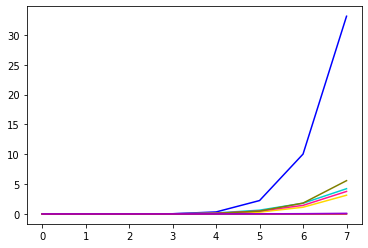

In [311]:
# Plot covs
dets = np.squeeze(np.linalg.det(covs))
n_vehicles = mus.shape[1]
x = np.arange(8)
for idx in range(n_vehicles):
    c = AGENT_COLORS[idx % NCOLORS]
    plt.plot(x, dets[idx], c=c)

Plot single Gaussians

In [379]:
dist = generate_vehicle_gmms(
        num_samples=1,
        z_mode=False, gmm_mode = False,
        full_dist = False, all_z_sep = False)

# Log Mixing Proportions
# not used with this setting
log_pis = dist.log_pis.cpu().detach().numpy()
# Parameters of Gaussians
mus = dist.mus.cpu().detach().numpy()
sigmas = dist.sigmas.cpu().detach().numpy()
covs = dist.get_covariance_matrix().cpu().detach().numpy()
Ls = dist.L.cpu().detach().numpy()
# assume that we are only using one component
# mus has shape (# vehicles, prediction_horizon, 2)
mus = mus[0,:,:,0]
# sigmas has shape (# vehicles, prediction_horizon, 2)
# sigmas are not used in plot
sigmas = sigmas[0,:,:,0]
# covs, Ls has shape (# vehicles, prediction_horizon, 2, 2)
covs = covs[0,:,:,0]
Ls = Ls[0,:,:,0]

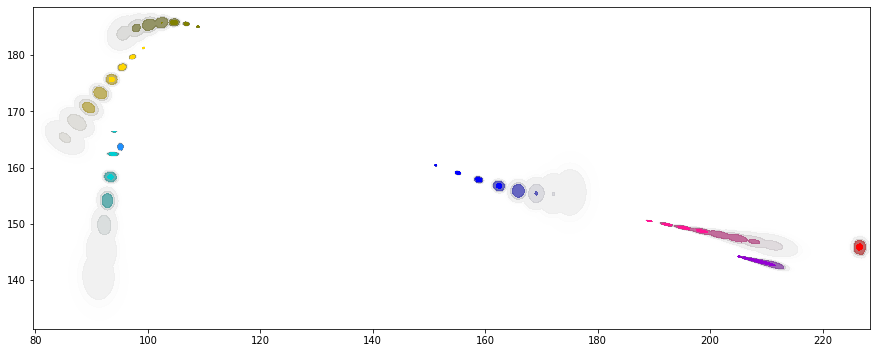

In [376]:
# contour plot all Gaussian's together
# uses possibly numerically unstable multivariate Gaussian distribution 

# extent = np.array([(0, scene.x_size), (0, scene.y_size)])
min_extent = np.min(mus.reshape((-1, 2)) - 3*sigmas.reshape((-1, 2)), axis=0)
max_extent = np.max(mus.reshape((-1, 2)) + 3*sigmas.reshape((-1, 2)), axis=0)
extent = np.array([min_extent, max_extent]).T
# TOL = 0.05
N = 600
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, ax = plt.subplots(figsize=(15, 15))

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
for v_idx in range(n_vehicles):
    v_mus = mus[v_idx]
    v_covs = covs[v_idx]
    Z = None
    for p_idx in range(mus.shape[1]):
        mu = v_mus[p_idx]
        cov = v_covs[p_idx]
        _Z = multivariate_gaussian(pos, mu, cov)
        Z = _Z if Z is None else np.max((Z, _Z), axis=0)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    ax.contourf(X, Y, Z, cmap=cmap, extend='max', levels=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5])

ax.set_aspect('equal')

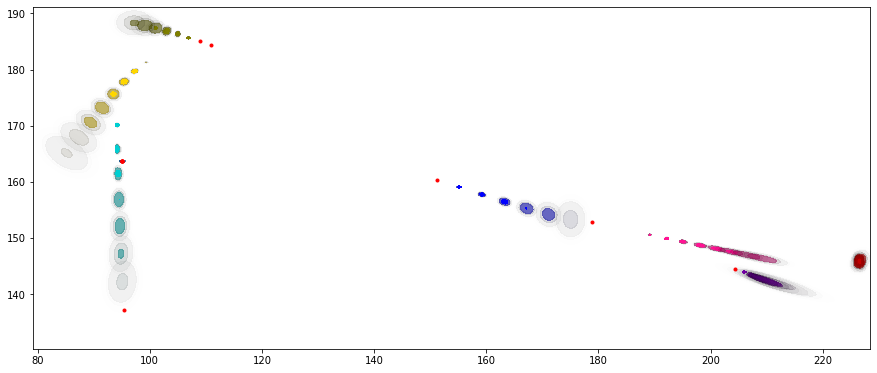

In [321]:
# contour plot Gaussian's one by one as multivariate Gaussian
# uses possibly numerically unstable multivariate Gaussian distribution 

D = 5
min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
TOL = 0.05
N = 400
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, ax = plt.subplots(figsize=(15, 15))

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
for v_idx in range(n_vehicles):
    v_mus = mus[v_idx]
    v_covs = covs[v_idx]
    for p_idx in range(prediction_horizon):
        mu = v_mus[p_idx]
        cov = v_covs[p_idx]
        Z = multivariate_gaussian(pos, mu, cov)
        if np.max(Z) < TOL:
            ax.plot(mu[0], mu[1], marker='o', markersize=3, color="red")
        else:
            cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
            ax.contourf(X, Y, Z, cmap=cmap, extend='max', levels=[0.001, 0.005, 0.01, 0.05, 0.1, 0.5])

ax.set_aspect('equal')

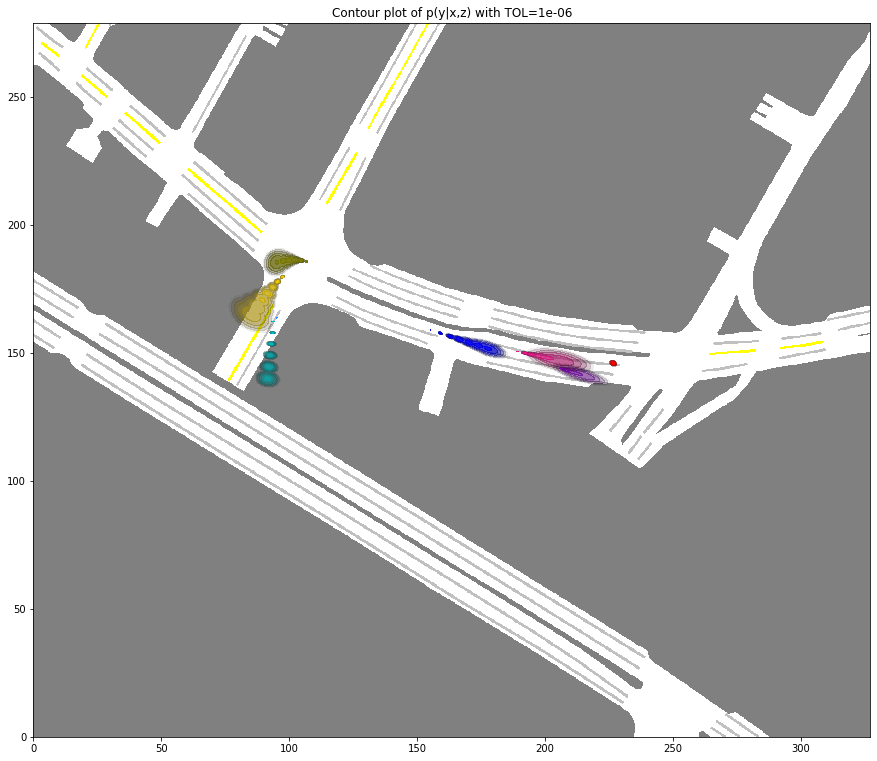

In [381]:
# contour plot all Gaussian's together
# uses numerically stable multivariate Gaussian based on Cholesky decomposition

D = 5
min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
extent = np.array([min_extent, max_extent]).T
TOL = 1e-6
N = 500
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, ax = plt.subplots(figsize=(15, 15))
render_roads(ax, scene, is_white=True)

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
for v_idx in range(n_vehicles):
    v_mus = mus[v_idx]
    v_Ls = Ls[v_idx]
    Z = None
    for p_idx in range(prediction_horizon):
        mu = v_mus[p_idx]
        L = v_Ls[p_idx]
        L_inv = np.linalg.inv(L)
        _Z = cholesky_mv_gaussian(pos, mu, L)
        Z = _Z if Z is None else np.max((Z, _Z), axis=0)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    ax.contourf(X, Y, Z, cmap=cmap, extend='max', locator=ticker.LogLocator())
    
ax.set_title(f"Contour plot of p(y|x,z) with TOL={TOL}")
ax.set_aspect('equal')
ax.set_facecolor("grey")

Get values of GMMs

In [231]:
dist = generate_vehicle_gmms(
        num_samples=1,
        z_mode=False, gmm_mode=False,
        full_dist=True, all_z_sep=False)
idx = 0
# Parameters of GMM
# Log Mixing Proportions
# log_pis has shape (# vehicles, prediction_horizon, # components)
log_pis = dist.log_pis.cpu().detach().numpy()[idx]
# Parameters of Gaussians
# mus, sigmas has shape (# vehicles, prediction_horizon, # components, 2)
mus = dist.mus.cpu().detach().numpy()[idx]
sigmas = dist.sigmas.cpu().detach().numpy()[idx]
# has shape (# vehicles, prediction_horizon, # components, 2, 2)
covs = dist.get_covariance_matrix().cpu().detach().numpy()[idx]
# Cholesky factorization of covariance matrix
L = dist.L.cpu().detach().numpy()[idx]

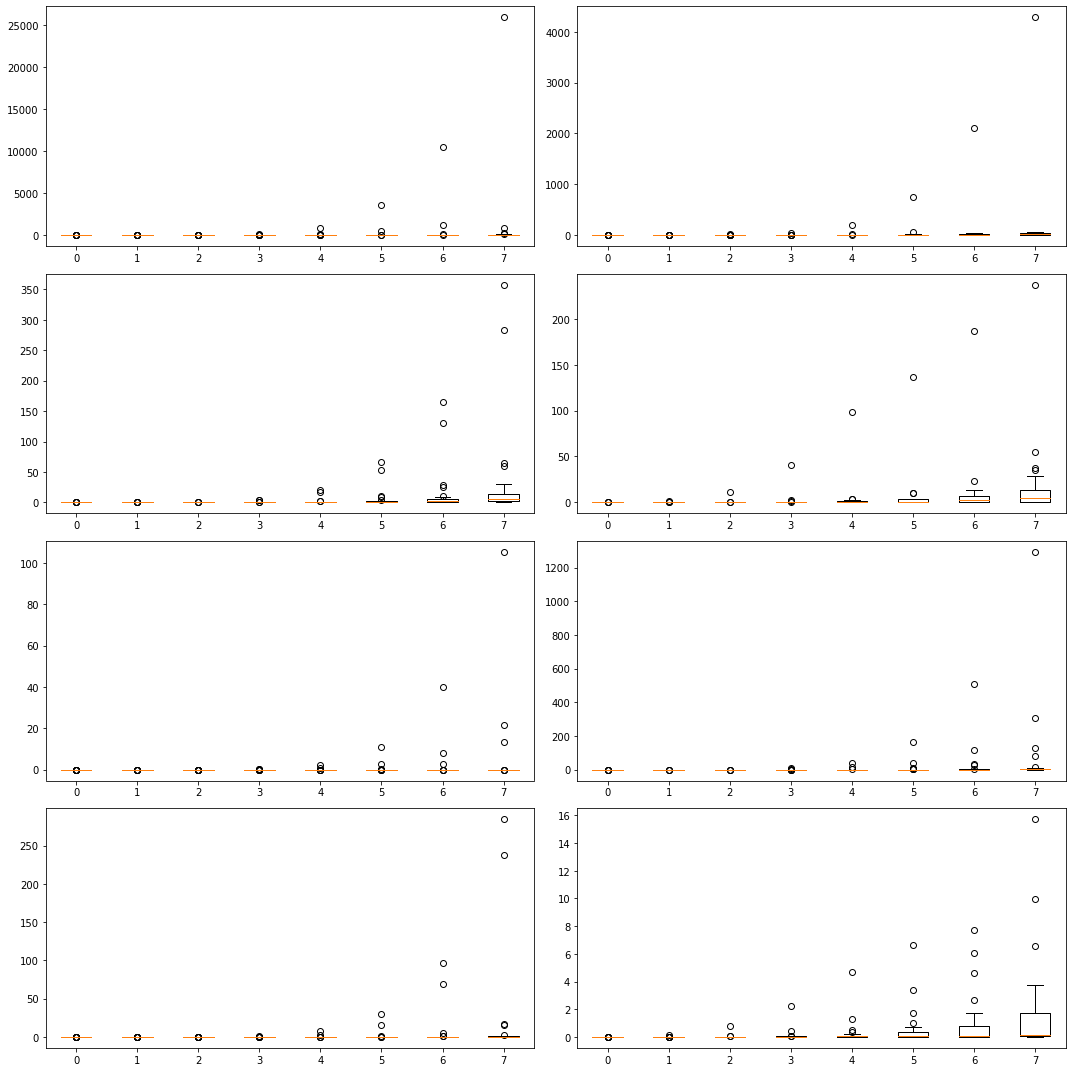

In [341]:
# Plot determinants of covariances, or condition number of covariances.

# dets = np.squeeze(np.linalg.det(L))**2
dets = np.squeeze(np.linalg.det(covs))
n_vehicles = mus.shape[0]
ph = mus.shape[1]
n_components = mus.shape[2]
x = np.arange(ph)

fig, axes = plt.subplots(n_vehicles // 2, 2, figsize=(15, 15))
axes = axes.ravel()

for idx in range(n_vehicles):
    c = AGENT_COLORS[idx % NCOLORS]
    labels = range(0, ph)
    datasets = [dets[idx,t] for t in labels]
    axes[idx].boxplot(datasets, labels=labels)

fig.tight_layout()

Plot the mixture of Gaussians (GMM)

In [15]:
dist = generate_vehicle_gmms(
        num_samples=1,
        z_mode=False, gmm_mode=False,
        full_dist=True, all_z_sep=False)

# Log Mixing Proportions
# not used with this setting
log_pis = dist.log_pis.cpu().detach().numpy()
# Parameters of Gaussians
mus = dist.mus.cpu().detach().numpy()
sigmas = dist.sigmas.cpu().detach().numpy()
covs = dist.get_covariance_matrix().cpu().detach().numpy()
Ls = dist.L.cpu().detach().numpy()

# assume that we are now using a mixture of Gaussians
# log_pis has shape (# vehicles, prediction_horizon, 2)
log_pis = log_pis[0,:,:]
# mus has shape (# vehicles, prediction_horizon, 2)
mus = mus[0,:,:]
# covs, Ls has shape (# vehicles, prediction_horizon, 2, 2)
covs = covs[0,:,:]
Ls = Ls[0,:,:]

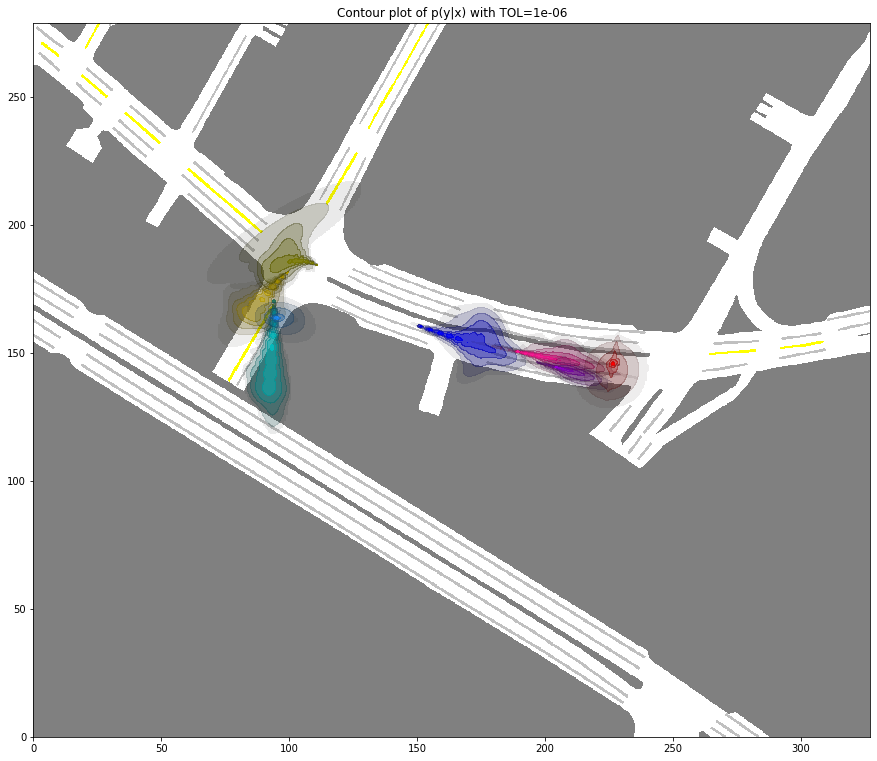

In [384]:
D = 3
min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
extent = np.array([min_extent, max_extent]).T
TOL = 1e-6
N = 300
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, ax = plt.subplots(figsize=(15, 15))
render_roads(ax, scene, is_white=True)

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
iter_vehicles = range(n_vehicles)
iter_ph = range(prediction_horizon)
for v_idx in iter_vehicles:
    v_log_pis = log_pis[v_idx]
    v_mus = mus[v_idx]
    v_Ls = Ls[v_idx]
    Zs = []
    for p_idx in iter_ph:
        vp_log_pis = v_log_pis[p_idx]
        vp_mus = v_mus[p_idx]
        vp_Ls = v_Ls[p_idx]
        Z = cholesky_mv_gaussian_mixture(pos, vp_log_pis, vp_mus, vp_Ls)
        Zs.append(Z)
    Z = np.max(Zs, axis=0)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    ax.contourf(X, Y, Z, cmap=cmap, extend='max', locator=ticker.LogLocator())
    
ax.set_title(f"Contour plot of p(y|x) with TOL={TOL}")
ax.set_aspect('equal')
ax.set_facecolor("grey")

I'm not able to get some other multivariate GMM functions working, probably due to numerical instablity.

/home/fireofearth/.local/miniconda3/envs/trajectron/lib/python3.6/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in sqrt
/home/fireofearth/.local/miniconda3/envs/trajectron/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp
/home/fireofearth/.local/miniconda3/envs/trajectron/lib/python3.6/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/fireofearth/.local/miniconda3/envs/trajectron/lib/python3.6/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


ValueError: cannot convert float NaN to integer

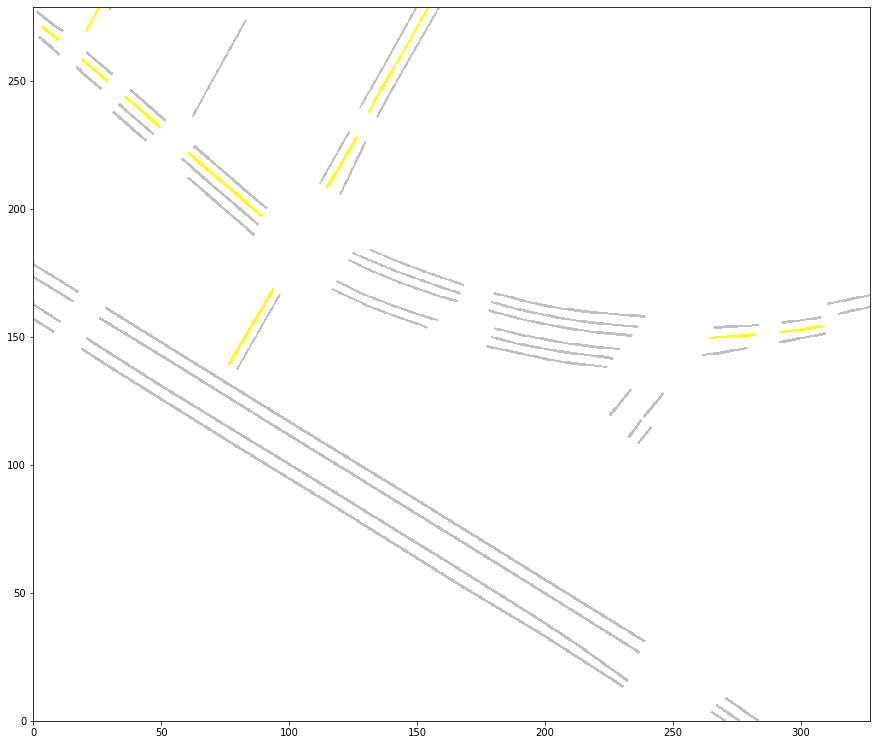

In [16]:
D = 3
min_extent = np.min(mus.reshape((-1, 2)) - D*sigmas.reshape((-1, 2)), axis=0)
max_extent = np.max(mus.reshape((-1, 2)) + D*sigmas.reshape((-1, 2)), axis=0)
extent = np.array([min_extent, max_extent]).T
TOL = 1e-6
N = 300
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gmm(pos, pis, mus, covs):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.
    
    TODO: numerically unstable
    """
    gaussians = []
    for idx in range(pis.shape[0]):
        mu = mus[idx]
        Sigma = covs[idx]
        n = mu.shape[0]
        Sigma_det = np.linalg.det(Sigma)
        Sigma_inv = np.linalg.inv(Sigma)
        N = np.sqrt((2*np.pi)**n * Sigma_det)
        # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
        # way across all the input variables.
        fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
        gaussian = np.exp(-fac / 2) / N
        gaussians.append(gaussian)
    gmm = np.zeros(gaussians[0].shape)
    for idx in range(pis.shape[0]):
        gmm += pis[idx]*gaussians[idx]
    gmm = np.nan_to_num(gmm)
    return gmm

fig, ax = plt.subplots(figsize=(15, 15))
# render_roads(ax, scene, is_white=True)

n_vehicles = mus.shape[0]
prediction_horizon = mus.shape[1]
iter_vehicles = range(n_vehicles)
iter_ph = range(prediction_horizon)
for v_idx in iter_vehicles:
    v_log_pis = log_pis[v_idx]
    v_mus = mus[v_idx]
    v_covs = covs[v_idx]
    Zs = []
    for p_idx in iter_ph:
        vp_log_pis = v_log_pis[p_idx]
        vp_mus = v_mus[p_idx]
        vp_covs = v_covs[p_idx]
        Z = multivariate_gmm(pos, vp_log_pis, vp_mus, vp_covs)
#         Z = cholesky_mv_gaussian_mixture(pos, vp_log_pis, vp_mus, vp_Ls)
        Zs.append(Z)
    Z = np.max(Zs, axis=0)
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    ax.contourf(X, Y, Z, cmap=cmap, extend='max', locator=ticker.LogLocator())
    
ax.set_title(f"Contour plot of p(y|x) with TOL={TOL}")
ax.set_aspect('equal')
# ax.set_facecolor("grey")

/home/fireofearth/.local/miniconda3/envs/trajectron/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/home/fireofearth/.local/miniconda3/envs/trajectron/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


ValueError: filled contour levels must be increasing

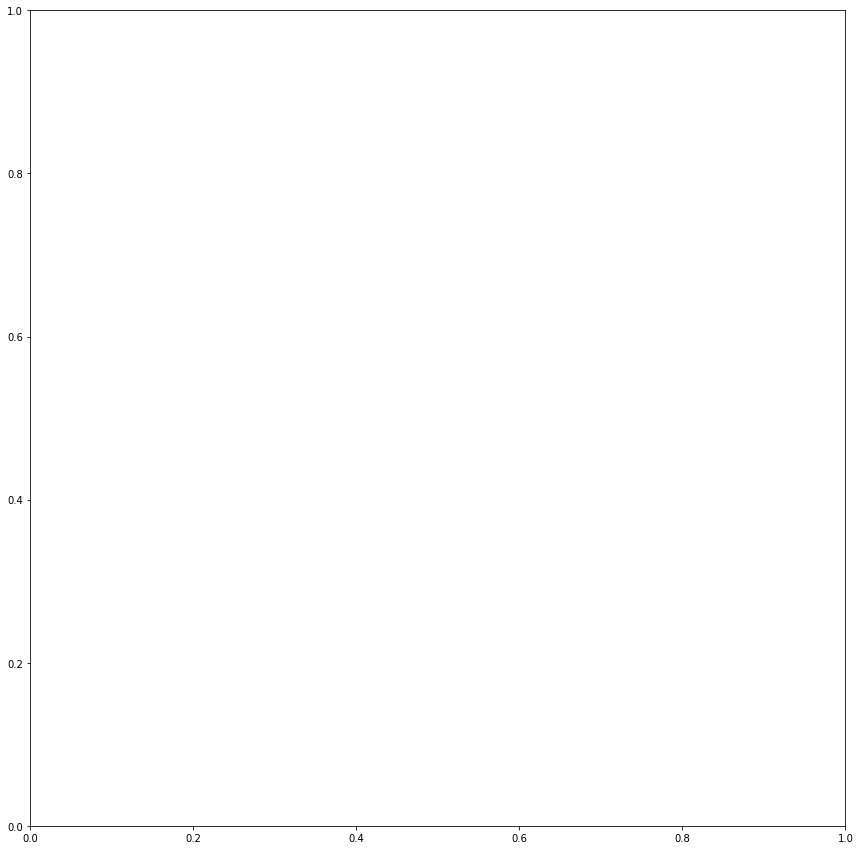

In [368]:
def multivariate_gmm(pos, pis, mus, covs):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.
    
    TODO: numerically unstable
    """
    gaussians = []
    for idx in range(pis.shape[0]):
        mu = mus[idx]
        Sigma = covs[idx]
        n = mu.shape[0]
        Sigma_det = np.linalg.det(Sigma)
        Sigma_inv = np.linalg.inv(Sigma)
        N = np.sqrt((2*np.pi)**n * Sigma_det)
        # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
        # way across all the input variables.
        fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
        gaussian = np.exp(-fac / 2) / N
        gaussians.append(gaussian)
    gmm = np.zeros(gaussians[0].shape)
    for idx in range(pis.shape[0]):
        gmm += pis[idx]*gaussians[idx]
    gmm = np.nan_to_num(gmm)
    return gmm

centers = mus.reshape((-1, 2))
cover = 2*sigmas.reshape((-1, 2))
min_extent = np.min(centers - cover, axis=0)
max_extent = np.max(centers + cover, axis=0)
extent = np.array([min_extent, max_extent]).T
TOL = 1e-6

N = 600
X = np.linspace(extent[0,0], extent[0,1], N)
Y = np.linspace(extent[1,0], extent[1,1], N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_aspect('equal')

for v_idx in range(mus.shape[0]):
    v_pis = pis[v_idx]
    v_mus = mus[v_idx]
    v_covs = covs[v_idx]
    Zs = []
    for p_idx in range(mus.shape[1]):
        p_pis = v_pis[p_idx]
        p_mus = v_mus[p_idx]
        p_covs = v_covs[p_idx]
        Z = multivariate_gmm(pos, p_pis, p_mus, p_covs)
        Zs.append(Z)
    Zs = np.array(Zs)
    Z = np.max(Zs, axis=0)
    # seems like the prob dist is not scaled properly?
    # print(np.max(Z))
    Z = np.ma.masked_where(Z < TOL, Z)
    cmap = colors.LinearSegmentedColormap.from_list('', ['none', AGENT_COLORS[v_idx % NCOLORS]])
    ax.contourf(X, Y, Z, cmap=cmap, extend='max', locator=ticker.LogLocator())

ax.set_aspect('equal')